In [1]:
from google.colab import files
uploaded = files.upload()



Saving Salary Data.csv to Salary Data.csv


In [2]:
import pandas as pd

df = pd.read_csv(next(iter(uploaded)))
df.head()


,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [4]:
# Step 2: Data Preprocessing

# 1. Drop completely empty rows (some are at the bottom of your dataset)
df.dropna(how='all', inplace=True)

# 2. Drop rows with missing salary values
df = df.dropna(subset=['Salary'])

# 3. Fill any remaining missing values (if any) using forward fill
df.fillna(method='ffill', inplace=True)

# 4. Encode categorical columns
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
categorical_cols = ['Gender', 'Education Level', 'Job Title']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 5. Define features and target
X = df.drop('Salary', axis=1)
y = df['Salary']

# 6. Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Check shapes
print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)

/tmp/ipython-input-3997176612.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Training features shape: (298, 5)
Test features shape: (75, 5)


In [5]:
# Step 3: Train Ensemble Models

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor

# 1. Initialize models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# 2. Combine them into a Voting Regressor
voting = VotingRegressor(estimators=[
    ('rf', rf),
    ('gb', gb)
])

# 3. Train models
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)
voting.fit(X_train, y_train)

print("Models trained successfully.")

Models trained successfully.


In [6]:
# Step 4: Evaluate Model Performance

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# 1. Make predictions
rf_preds = rf.predict(X_test)
gb_preds = gb.predict(X_test)
voting_preds = voting.predict(X_test)

# 2. Define evaluation function
def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} Performance:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.2f}")
    print("-" * 30)

# 3. Evaluate each model
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("Gradient Boosting", y_test, gb_preds)
evaluate_model("Voting Regressor", y_test, voting_preds)

Random Forest Performance:
  R² Score: 0.9401
  RMSE: 11981.83
------------------------------
Gradient Boosting Performance:
  R² Score: 0.9264
  RMSE: 13287.07
------------------------------
Voting Regressor Performance:
  R² Score: 0.9361
  RMSE: 12377.48
------------------------------


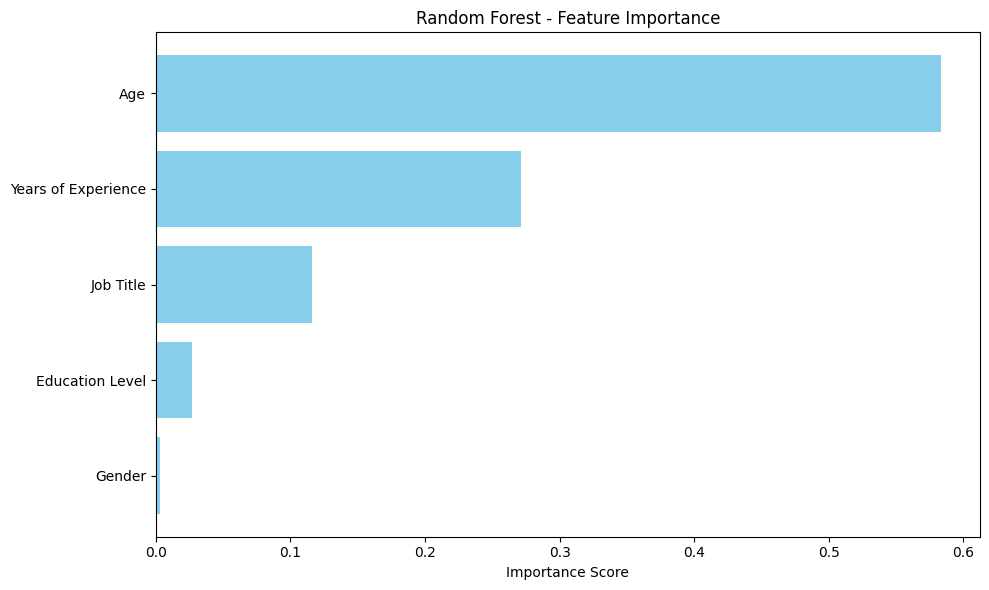

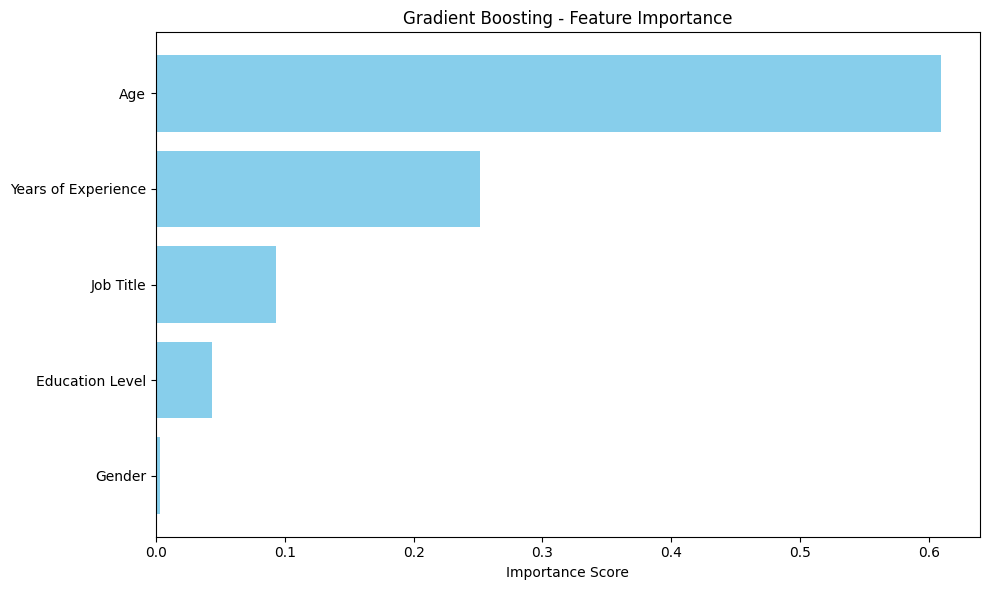

In [7]:
# Step 5: Visualize Feature Importance

import matplotlib.pyplot as plt

def plot_feature_importance(model, model_name):
    importances = model.feature_importances_
    feature_names = X.columns

    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    sorted_features = [feature_names[i] for i in indices]
    sorted_importances = importances[indices]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.title(f"{model_name} - Feature Importance")
    plt.barh(sorted_features[::-1], sorted_importances[::-1], color='skyblue')
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

# Plot for Random Forest
plot_feature_importance(rf, "Random Forest")

# Plot for Gradient Boosting
plot_feature_importance(gb, "Gradient Boosting")

In [8]:
import joblib

# Save the trained model
joblib.dump(voting, 'salary_predictor_model.pkl')
print("Model saved as 'salary_predictor_model.pkl'")

Model saved as 'salary_predictor_model.pkl'


In [9]:
# Load the model
loaded_model = joblib.load('salary_predictor_model.pkl')

# Example: Predict salary for a new employee
# Format: [Age, Gender, Education Level, Job Title, Years of Experience]
# You must encode categorical values using the same LabelEncoders used earlier

# Example input (customize as needed)
sample_input = pd.DataFrame([{
    'Age': 30,
    'Gender': label_encoders['Gender'].transform(['Female'])[0],
    'Education Level': label_encoders['Education Level'].transform(["Master's"])[0],
    'Job Title': label_encoders['Job Title'].transform(['Data Scientist'])[0],
    'Years of Experience': 4
}])

# Predict salary
predicted_salary = loaded_model.predict(sample_input)
print(f"Predicted Salary: ${predicted_salary[0]:,.2f}")

Predicted Salary: $71,379.70
